# The Spark Foudation Intership Task 2
## By Khaled Sherif

## Prediction using Unsupervised Ml
The Task is to predict the optimal number of k (clusters) of unlabeld data (iris dataset)<br>
and represent it visually<br>
Dataset can be found here https://bit.ly/3kXTdox (We imported it using sklearn.datasets)

## Steps performed to create the Supervised model
<ul>
<li>Reading and exploring the data</li>
<li>Preparing the data</li>
<li>Finding the optimum number of clusters manually</li>
<li>Finding the optimum number of clusters using Elbow method</li>
<li>Training model</li>
<li>Visualizing clusters</li>
</ul>

In [191]:
# Importing all libraries required in this notebook
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Reading and exploring the data
Lets start by importing our data, exploring and visualizing it.

In [3]:
# Loading imported data and converting it to dataframe
iris_data = load_iris()
iris_dataset = pd.DataFrame(iris_data.data, columns = iris_data.feature_names)

In [4]:
# Reading dataset
iris_dataset.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [5]:
#Checking for dtypes and missing data
iris_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [6]:
#Dataset summary statistics
iris_dataset.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Since all features in our dataset are in one unit (cm) that will help us plot all the distributions of them in one figure to better understand our clusters.

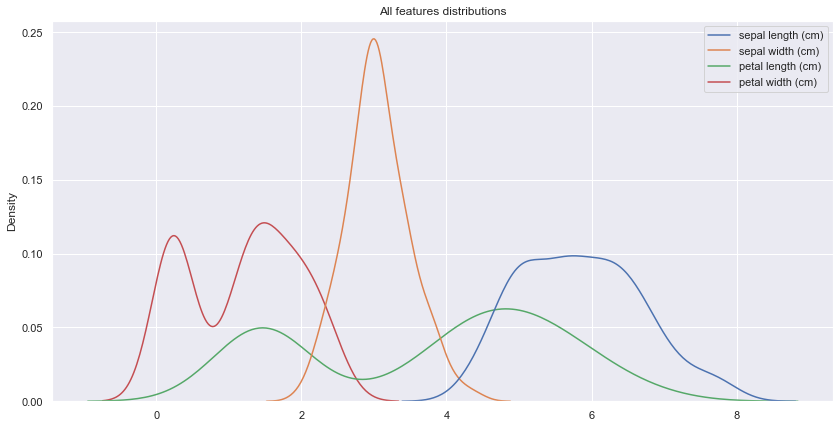

In [7]:
#plotting distribtions
sns.set(rc={"figure.figsize":(14, 7)})
g = sns.kdeplot(data=iris_dataset)
g.set(title='All features distributions');


From the Fig we can notice the following:<br>
<ol>
<li>We have 2 features(petal length & petal width) with bimodal distribions(Thats expected as they represent the distributions of classes of multiple clusters</li><br>
<li>Sepal width distribution curve is unimodal, tall and narrow which indicates the low variance(small std) for this featuer.</li><br>
<li>Sepal length distribtion is unimodal, short and wide which indicates a high variance(large std) compared to Sepal width.</li>
</ol>

In [8]:
iris_data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Now lets uderstand our data further by seeing how they correlate to each other and by plotting scatter plots of all features compared to each other to understand the correlation in our data

In [9]:
# Finding pairwise correlation of all columns in Irsis dataset
iris_dataset.corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


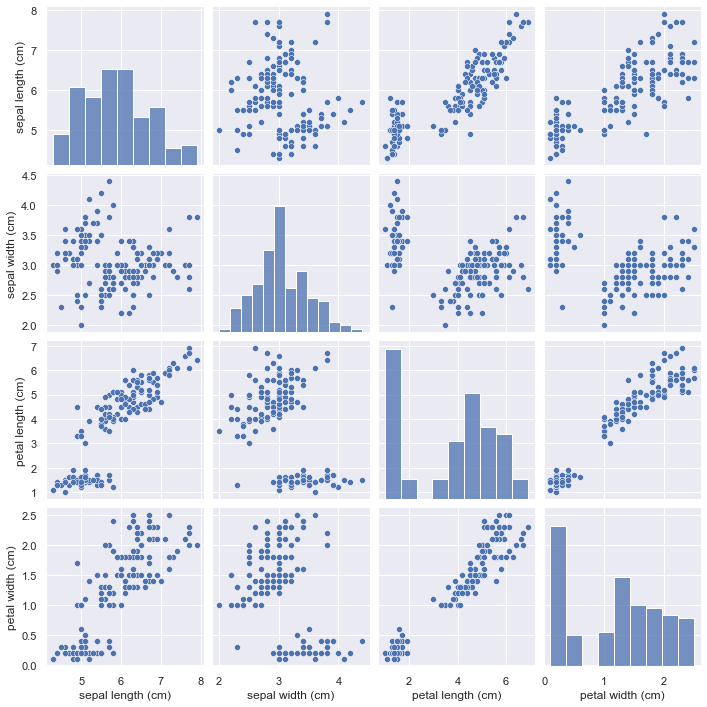

In [255]:
#Plotting pairplot of the Iris dataset
sns.set(rc={"figure.figsize":(14, 7)})
g = sns.pairplot(iris_dataset)

From the plots above we conclude:<br>
<ol>
<li>All features columns show strong correlation to each other except Sepal width which showed in the distribution fig above to have low variance</li><br>
<li>We can realize a primary guide for clusterig our data in almost each plot before even building our model. We can see how our data is seperated lineary in each scatter plot and how each feature plays an important clustering role</li><br>
<li>We can obviousy notice that all features makes our data lineary separable when plotted in with petal length column, that could really be helpful when visualizing our clusters to use sepal length as xlabel and other features as ylabel,also we will be able to use that to make an intuition about the optimal number of clusters before using Elbow method we will see that in a moment</li><br>


### Finding the optimal number of clusters
Sofar good we know which feature makes our data lineary separable the most we will use it as xlabel and train a kmeans model giving it a range of k values starting from 1 and plot our xlabel(sepal length) with each feature in the data to see at which k our predicted clusters are lineary separable at this point our optimal K value will be K+1 since our data is n_dimentional represented on 2d scatter plots for n features.

In [253]:
#declaring xlabel and ylabels mentioned in the above conclusion
xlabel = iris_dataset.columns[2]
ylabels = [iris_dataset.columns[0], iris_dataset.columns[1], iris_dataset.columns[3]]
#Model input
input = iris_dataset.iloc[:, :].values

def colors(points):

    """
    take an array of ints ranging from 0 to 4 and map them
    to color values

    parameters:
    arg1 (array/list): array of ints

    returns:
    list : list of colors
    """
    # Color values for ints(keys)
    clusters_colors = {0:'#ff293e', 1:'#15942a', 2:'#d66800', 3:'#1940ff', 4:'#420080'}
    colors = []
    
    for point in points:
      colors.append(clusters_colors[point])
    
    return colors


def Optimal_k_analysis(xlabel, ylabels, max_k):

    """
    Plot multiple scatter subplots for each no of k clusters using single column as xlabel(x axis)
    and n multiple columns as ylabel(y axis). If max_k = 5 it plots an n rows of 5 plots in each row using
    a ylabel in each row.

    parameters:
    arg1 (xlabel): a column name(eg. petal length)
    arg2 (ylabels): list of column names
    arg2 (max_k): max number of k clusters to be used in the model and plotted

    """


    for i_label in ylabels:
        plt.figure(figsize=(20, 4))

        #Making, fitting model and plotting predicted clusters for each k value
        for k in range(1,max_k+1):
            kmeans = KMeans(n_clusters=k)
            a = kmeans.fit_predict(input)
            plt.subplot(1,max_k,k)
            plt.title('Clusters')
            plt.ylabel(i_label)
            plt.scatter(iris_dataset[xlabel], iris_dataset[i_label], c=colors(a))
            plt.scatter(kmeans.cluster_centers_[:, iris_dataset.columns.get_loc(xlabel)],
                    kmeans.cluster_centers_[:, iris_dataset.columns.get_loc(i_label)], s = 100, c = 'black', label = 'Centroids')




            plt.xlabel('k='+str(k))


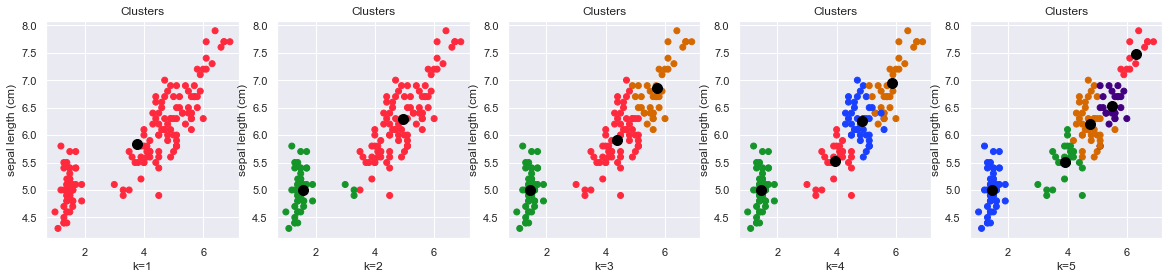

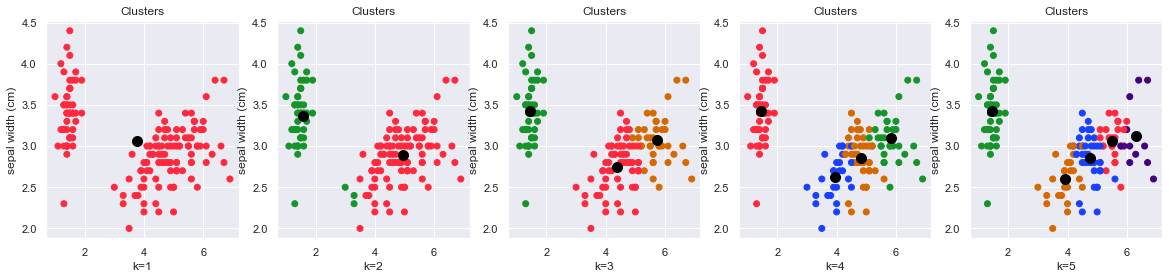

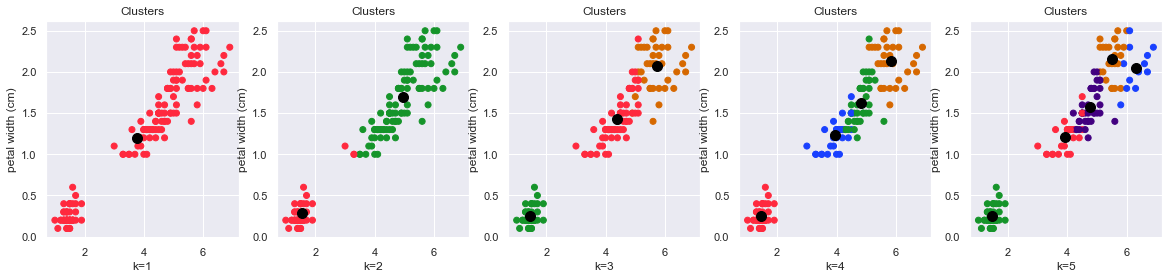

In [254]:
#Plotting figures
Optimal_k_analysis(xlabel, ylabels, 5)

Good we can obviously notice that clusters are best seperated when k = 2 with each feature in ylabel, thus we conclude that the optimal value of k is k+1 because as we mentioned above these are 2 dimensional plots if they all these features are represented in one row on n dimensional plot we would be seeing these points best clustered at k = 3.<br><br>
But we still can't be sure, also intuitive approaches are just for analysis, purposes so we can't consider k = 3 to be the last answer before using a practical method to be sure, there are alot of mathematical methods there for finding optimal k number, we will be using Elbow method which is one of the most popular methods for such cases, its known to be relatively fast and suitable for such cases where data can be lineary separable.



Elbow method code reference: https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

In [219]:
# Applying Elobow method 
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
max_k = range(1, 10)

for k in max_k:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(input)
 
    distortions.append(sum(np.min(cdist(iris_dataset, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / iris_dataset.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(iris_dataset, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / iris_dataset.shape[0]
    mapping2[k] = kmeanModel.inertia_

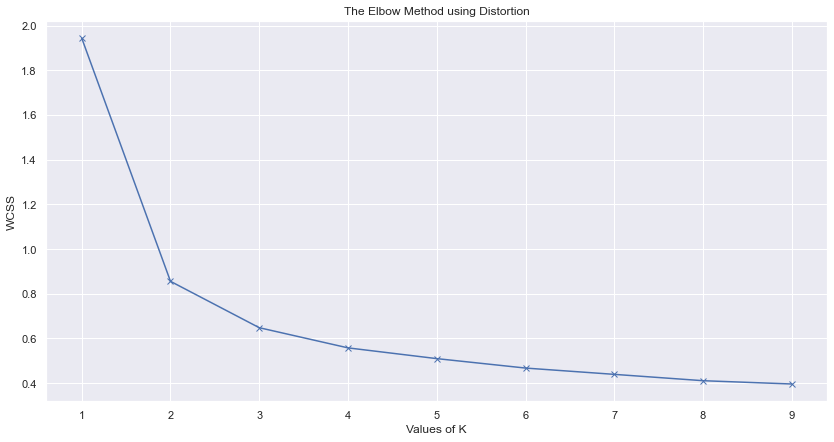

In [227]:
#Plotting WCSS for each value of K
plt.figure(figsize=(14, 7))
plt.plot(max_k, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('WCSS')
plt.title('The Elbow Method using Distortion')
plt.show()

We can obviously see how the elbow appears at k = 3 which means that this the right optimal number of k and we are sure of that above in discovering that manually now as a final step lets train our model

### Training model


In [310]:
# Making a Kmeans model of k = 3 ad fitting it to input
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(input)

### Visualizing Clusters


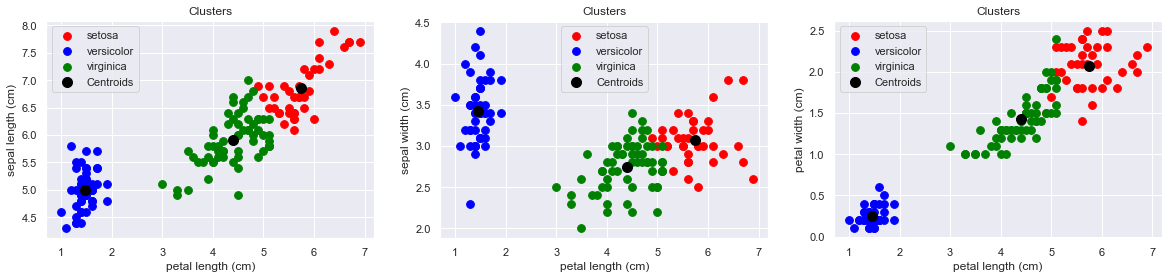

In [360]:
#We got that from iris imported bunch object
lables = iris_data.target_names
#Plotting subplot scatters of clusters 
plt.figure(figsize=(20, 4))
for i_label, label_name in zip(ylabels, lables):

    #Making, fitting model and plotting predicted clusters for each k value
    plt.subplot(1, 3, ylabels.index(i_label)+1)
    plt.title('Clusters')
    plt.xlabel(xlabel)
    plt.ylabel(i_label)
    plt.scatter(input[clusters == 0, iris_dataset.columns.get_loc(xlabel)], input[clusters == 0, iris_dataset.columns.get_loc(i_label)], 
                s = 60, c = 'red', label = lables[0])    
    plt.scatter(input[clusters == 1, iris_dataset.columns.get_loc(xlabel)], input[clusters == 1, iris_dataset.columns.get_loc(i_label)], 
                s = 60, c = 'blue', label = lables[1])   
    plt.scatter(input[clusters == 2, iris_dataset.columns.get_loc(xlabel)], input[clusters == 2, iris_dataset.columns.get_loc(i_label)], 
                s = 60, c = 'green', label = lables[2])

    plt.scatter(kmeans.cluster_centers_[:, iris_dataset.columns.get_loc(xlabel)],
            kmeans.cluster_centers_[:, iris_dataset.columns.get_loc(i_label)], s = 100, c = 'black', label = 'Centroids')
    plt.legend()

We can pretty see each predicted cluster with its centroid in 2d scatter plots shapes lets finaly print a 3d shape based on these features that will make more sense to our predicted clusters

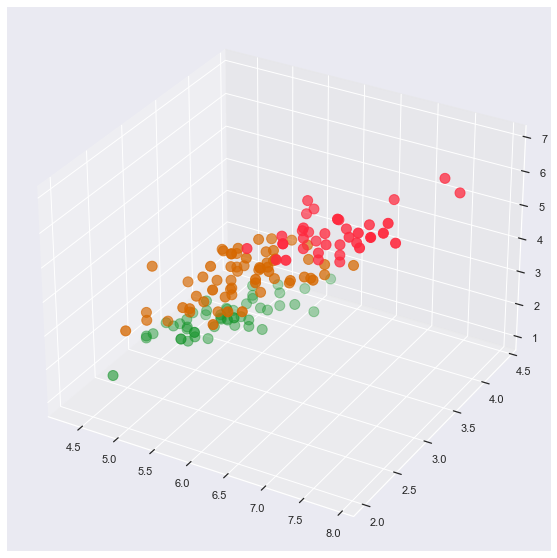

In [358]:
# Plotting a 4d scatter for the predicted clusters
fig = plt.figure(figsize=(20, 10))
ax = fig.gca(projection='3d');

x = iris_dataset.iloc[:, 0].values
y = iris_dataset.iloc[:, 1].values
z = iris_dataset.iloc[:, 2].values
c = iris_dataset.iloc[:, 3].values

ax.scatter(x, y, z, c, s = 100, c = colors(clusters), label = 'Centroids');

We can clearly see now how our 3 clusters appear to be separated when all featres are represented on a 4d plot

## Conclusion
<ul>
<li>Iris dataset has 2 features(petal length & petal width) with bimodal distributions, one feature with unimodal tall and narrow distribution curve(Sepal width) which indicates the low variance(small std) and one unimodal feature with short and wide distribution curve(Sepal length) which indicates a high variance(large std).
</li>
<li>The Iris dataset is linearly separable in scatter plots so that the optimum numbe of clusters K, can be guessed just by looking at the plots.</li>
<li>The optimum number of clusters k is 3.</li>
<li>The clusters appear to be seperated when all features are plotted on 3d scatter instead of 2d scatters.</li>
</ul>